In [1]:
# Francisco Dominguez Mateos
# 01/09/2020
# Mixture Density Networks
#From:https://towardsdatascience.com/deep-learning-with-jax-and-elegy-c0765e3ec31a
#     https://github.com/cgarciae/simple-mixture-models
#for some reason pixture probability are higher than one and
#then loss is lower than zero. Biside that it seem to fit the data

In [19]:
import numpy as onp
import jax
import jax.numpy as np
from jax import grad, jit, vmap, value_and_grad
from jax import random
from jax.experimental import stax
from jax.experimental.stax import (parallel, FanInConcat, 
                                  FanOut, Dense, Relu, Softmax)
from jax.experimental import optimizers

from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt


In [3]:
# Generate key which is used to generate random numbers
rng = random.PRNGKey(2)

In [4]:
def safe_log(x):
    return np.log(np.maximum(x, 1e-6))

In [5]:
#this layer make the variance allway positive it is second column
def MixNetAux():
    def init_fun(key,input_shape):
        return input_shape,None
    def apply_fun(params, inputs, **kwargs):
        """ Compute the forward pass for each example individually """
        inputs=jax.ops.index_update(inputs, jax.ops.index[..., 1], 1.0 + jax.nn.elu(inputs[..., 1]))
        return inputs
    return init_fun, apply_fun

In [6]:
k=5
gaussians=[
    stax.serial(
        Dense(2),
        MixNetAux()
    ) for _ in range(k)]
gaus_nets_pair=stax.serial(
    FanOut(k),
    parallel(*gaussians),
    FanInConcat()
)
prob_net_pair =stax.serial(Dense(k),Softmax)
mix_init, mix_net = stax.serial(
    Dense(64),
    Relu,
    FanOut(2),
    parallel(gaus_nets_pair,prob_net_pair)
)

In [7]:
input_shape=(-1,1)
output_shape,params=mix_init(rng,input_shape)
print(output_shape)
#for l in params:
#    print(l[0].shape)#,l[1].shape)
fake_data=random.uniform(rng,(2,1))
fake_targets=random.uniform(rng,(2,1))
pred=mix_net(params,fake_data)
print(pred[0].shape,pred[1].shape)

((-1, 10), (-1, 5))
(2, 10) (2, 5)


In [8]:
def loss(params,inputs,t):
    y_pred=mix_net(params,inputs)
    y,probs=y_pred
    idx=np.array(range(k))
    means =y[...,idx*2]
    sigmas=y[...,idx*2+1]
    #very importan (automatic), must be one for each gaussian
    #t = np.broadcast_to(t, (t.shape[0], means.shape[1]))
    pgaus=jax.scipy.stats.norm.pdf(t,loc=means,scale=sigmas)
    p=-safe_log(np.sum(probs*pgaus,axis=1))
    return np.mean(p)

In [9]:
means =np.array([0,0,0,0]).reshape(2,2)
sigmas=np.array([1,1,1,1]).reshape(2,2)
values=np.array([-2,-2]).reshape(2,1)
probs=np.array([0.5,0.5,0.25,0.75]).reshape(2,2)
pgaus=jax.scipy.stats.norm.pdf(values,loc=means,scale=sigmas)
print(probs*pgaus)
p=np.sum(probs*pgaus,axis=1)
print(p.shape,p)

[[0.02699548 0.02699548]
 [0.01349774 0.04049322]]
(2,) [0.05399096 0.05399096]


In [10]:
fake_target=random.uniform(rng,(2,1))
l=loss(params,fake_data,fake_target)
print(l,l.shape)

1.0648155 ()


In [11]:
step_size = 3e-4
opt_init, opt_update, get_params = optimizers.adam(step_size)
opt_state = opt_init(params)

In [12]:
@jit
def update(opt_state, x, y, ):
    """ Compute the gradient for a batch and update the parameters """
    params=get_params(opt_state)
    value, grads = value_and_grad(loss)(params, x, y)
    opt_state = opt_update(0, grads, opt_state)
    return opt_state
    #return get_params(opt_state), opt_state, value

In [13]:
#opt_state=update(opt_state,fake_data,fake_targets)
#params=get_params(opt_state)
#l=loss(params,fake_data,fake_targets)
#print(l)

In [14]:
def visualize_data(X_train, y_train):
    #plt.scatter(X_train[..., 0], y_train[..., 0])
    #plt.show()

    m = LinearRegression()
    m.fit(X_train, y_train)
    x = np.linspace(X_train.min(), X_train.max(), 100)[..., None]
    y = m.predict(x)
    plt.scatter(X_train[..., 0], y_train[..., 0])
    plt.plot(x, y[:, 0], "k")
    plt.show()

(300, 1) (300, 1)


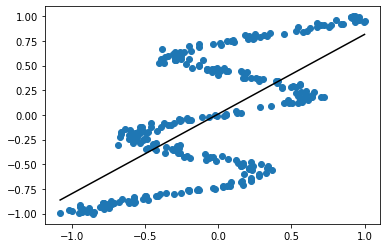

In [15]:
noise = np.float32(onp.random.normal(size=(300, 1)))  # random noise
y_train = np.float32(onp.random.uniform(-10.5, 10.5, (1, 300))).T
X_train = np.float32(np.sin(0.75 * y_train) * 7.0 + y_train * 0.5 + noise * 1.0)

X_train = X_train / np.abs(X_train.max())
y_train = y_train / np.abs(y_train.max())

print(X_train.shape,y_train.shape)
visualize_data(X_train, y_train)

In [16]:
def visualize_model(X_train, y_train):

    x = np.linspace(X_train.min(), X_train.max(), 100)[..., None]
    y, probs = mix_net(params,x)
    idx=np.array(range(k))
    means =y[...,idx*2]
    sigmas=y[...,idx*2+1]
    plt.figure()
    plt.scatter(X_train[..., 0], y_train[..., 0])

    for i in range(k):
        p = probs[:, i] > 0.01
        plt.plot(x[p], means[p,i], "k")
        plt.plot(x[p], means[p,i] + sigmas[p,i], "r")
        plt.plot(x[p], means[p,i] - sigmas[p,i], "r")

    #plt.figure()
    #plt.title("P(z = k | x)")
    for i in range(k):
        sum_prev = probs[:, :i].sum(axis=-1)*2-1
        sum_current = probs[:, : i + 1].sum(axis=-1)*2-1
        plt.plot(x[..., 0], sum_current)
        plt.fill_between(x[..., 0], sum_current, sum_prev, alpha=0.30)
    plt.show()

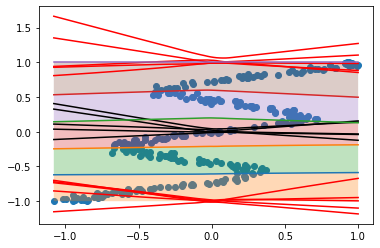

np.min(probs) 0.15871008
probs.shape (300, 5)
np.min(means) -0.12223683
np.min(sigmas) 0.7693417
np.max(pgaus) 0.4586447
pgaus.shape (300, 5)
np.max(p) 0.39896894
0 1.1158915


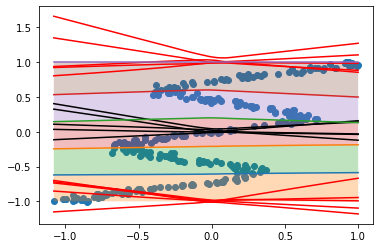

np.min(probs) 0.023579976
probs.shape (300, 5)
np.min(means) -1.0725592
np.min(sigmas) 0.1449216
np.max(pgaus) 2.4260187
pgaus.shape (300, 5)
np.max(p) 2.0417447
500 0.54681224


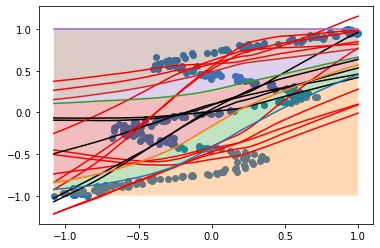

np.min(probs) 0.010058609
probs.shape (300, 5)
np.min(means) -1.1187032
np.min(sigmas) 0.09078252
np.max(pgaus) 3.4205859
pgaus.shape (300, 5)
np.max(p) 2.8209004
1000 0.47062513


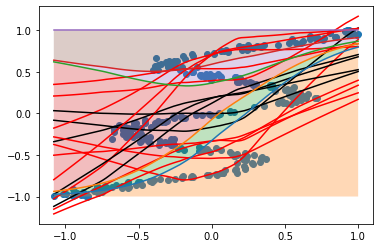

np.min(probs) 0.003822703
probs.shape (300, 5)
np.min(means) -1.0183847
np.min(sigmas) 0.021469235
np.max(pgaus) 12.495933
pgaus.shape (300, 5)
np.max(p) 9.641431
1500 0.2835118


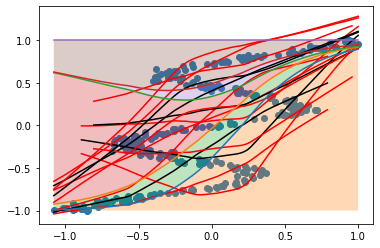

np.min(probs) 0.0015014263
probs.shape (300, 5)
np.min(means) -0.9901114
np.min(sigmas) 0.010284185
np.max(pgaus) 25.995232
pgaus.shape (300, 5)
np.max(p) 21.276892
2000 -0.04945226


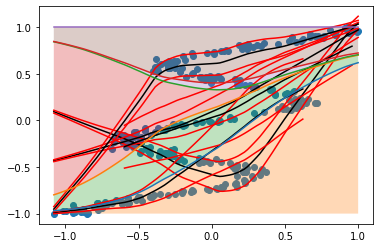

np.min(probs) 0.0006102662
probs.shape (300, 5)
np.min(means) -1.2457898
np.min(sigmas) 0.0031763911
np.max(pgaus) 39.35261
pgaus.shape (300, 5)
np.max(p) 34.43349
2500 -0.31228885


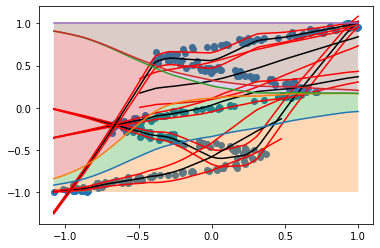

np.min(probs) 0.000960243
probs.shape (300, 5)
np.min(means) -1.2485176
np.min(sigmas) 0.0034829378
np.max(pgaus) 33.61961
pgaus.shape (300, 5)
np.max(p) 29.97117
3000 -0.5443298


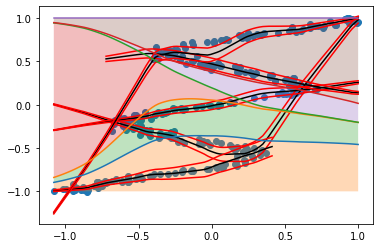

np.min(probs) 0.0022547906
probs.shape (300, 5)
np.min(means) -1.2183362
np.min(sigmas) 0.004507065
np.max(pgaus) 50.784447
pgaus.shape (300, 5)
np.max(p) 23.749004
3500 -0.8814817


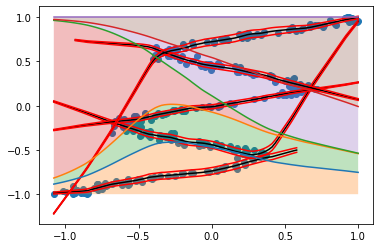

np.min(probs) 0.0048178583
probs.shape (300, 5)
np.min(means) -1.2043033
np.min(sigmas) 0.002764225
np.max(pgaus) 90.334076
pgaus.shape (300, 5)
np.max(p) 21.16681
4000 -0.99930376


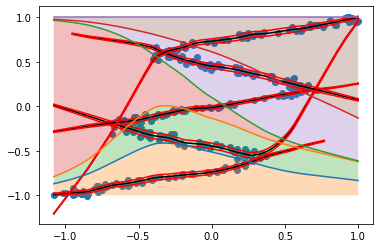

np.min(probs) 0.004881491
probs.shape (300, 5)
np.min(means) -1.1980852
np.min(sigmas) 0.001865387
np.max(pgaus) 101.33569
pgaus.shape (300, 5)
np.max(p) 19.337732
4500 -1.046501


In [17]:
for i in range(5000):
    opt_state=update(opt_state,X_train,y_train)
    if i%500==0:
        visualize_model(X_train,y_train)
        params=get_params(opt_state)
        y,probs=mix_net(params,X_train)
        print("np.min(probs)",np.min(probs))
        print("probs.shape",probs.shape)
        idx=np.array(range(k))
        means =y[...,idx*2]
        print("np.min(means)",np.min(means))
        sigmas=y[...,idx*2+1]
        print("np.min(sigmas)",np.min(sigmas))
        t_ext=np.broadcast_to(y_train, (y_train.shape[0], means.shape[1]))
        pgaus=jax.scipy.stats.norm.pdf(t_ext,loc=means,scale=sigmas)
        print("np.max(pgaus)",np.max(pgaus))
        print("pgaus.shape",pgaus.shape)
        p=np.sum(probs*pgaus,axis=1)
        print("np.max(p)",np.max(p))
        l=loss(params,X_train,y_train)
        print(i,l)

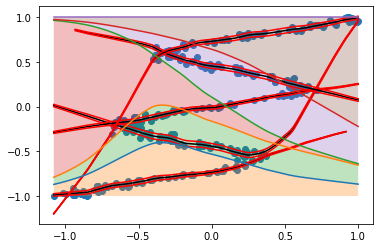

In [18]:
visualize_model(X_train,y_train)